# Premier League Maç Sonuçları Tahmin Modeli

### Projeye Genel Bakış

Bu not defteri, İngiltere Premier League maçlarının sonuçlarını tahmin etmek için istatistiksel bir makine öğrenmesi modeli geliştirir. Projenin temel yaklaşımı, maçın nihai sonucunu (Galibiyet, Beraberlik, Mağlubiyet) doğrudan sınıflandırmak yerine, her takımın **atması beklenen gol sayısını** tahmin etmektir. Bu yöntem, spor analizlerinde sıkça kullanılan Poisson dağılımına dayanır ve daha esnek ve isabetli tahminler üretme potansiyeline sahiptir.

### Benimsenen Yöntem: Poisson Dağılımına Dayalı Gol Tahmini

Modelin çekirdeğini, her takım için ayrı ayrı gol beklentisi üreten iki uzman model oluşturur:

1.  **Ev Sahibi Gol Uzmanı:** Ev sahibi takımın hücum performansı ve rakip takımın deplasman savunma istatistiklerine dayanarak ev sahibinin atması beklenen gol sayısını tahmin eder.
2.  **Deplasman Gol Uzmanı:** Deplasman takımının hücum performansı ve ev sahibi takımın iç saha savunma istatistiklerine dayanarak deplasman takımının atması beklenen gol sayısını tahmin eder.

Bu iki modelden elde edilen beklenen gol sayıları, Poisson olasılık kütle fonksiyonu kullanılarak tüm olası maç skorlarının (0-0, 1-0, 2-1, 1-1, vb.) gerçekleşme olasılıklarını hesaplamak için kullanılır. Son olarak, bu skor olasılıkları toplanarak maçın nihai sonucu için **Ev Sahibi Galibiyeti, Beraberlik ve Deplasman Galibiyeti** olasılıkları elde edilir.

### Not Defterindeki Adımlar

Bu projede izlenen adımlar şunlardır:

1.  **Veri Hazırlama ve Özellik Mühendisliği:**
    *   `epl_final.csv` veri seti yüklenir, temizlenir ve maç tarihine göre kronolojik olarak sıralanır.
    *   **Dinamik ELO Reytingi:** Her maçtan sonra gol farkını da hesaba katarak güncellenen gelişmiş bir ELO puanlama sistemi uygulanır.
    *   **Form ve Güç Metrikleri:** Takımların son 5 maçlık form durumlarını (atılan/yenilen gol ortalamaları, toplanan puanlar) ve sezon içindeki göreceli hücum/savunma güçlerini yansıtan özellikler oluşturulur.

2.  **Model Eğitimi ve Optimizasyonu:**
    *   Yukarıda bahsedilen "Ev Sahibi" ve "Deplasman" gol uzmanları olarak iki ayrı `XGBoost Regressor` modeli eğitilir.
    *   Her iki modelin de tahmin performansını en üst düzeye çıkarmak için `RandomizedSearchCV` kullanılarak hiperparametre optimizasyonu yapılır.

3.  **Tahmin ve Değerlendirme:**
    *   Optimize edilmiş modeller kullanılarak test seti için beklenen gol sayıları tahmin edilir.
    *   Bu beklentiler, en yakın tam sayıya yuvarlanarak en olası skor ve dolayısıyla maç sonucu belirlenir.
    *   Modelin genel doğruluğu, sınıflandırma raporu ve karışıklık matrisi gibi metriklerle değerlendirilir.

4.  **İnteraktif Tahmin Fonksiyonu:**
    *   Not defterinin sonunda, kullanıcının belirlediği iki takım arasındaki bir maçın sonucu için olasılıkları hesaplayan ve sunan bir fonksiyon yer alır.

----

### Adım 1: Veri Yükleme ve Özellik Mühendisliği

Bu bölüm, modelimizi eğitmek için gerekli olan tüm veri hazırlama ve özellik oluşturma adımlarını içerir. Tüm işlemler, veri sızıntısını (data leakage) önlemek amacıyla maçların kronolojik sırasına sadık kalınarak gerçekleştirilir.

#### Gerçekleştirilen İşlemler:

1.  **Veri Yükleme ve Temizleme:**
    *   `epl_final.csv` dosyası bir Pandas DataFrame'e yüklenir.
    *   `MatchDate` sütunu `datetime` formatına dönüştürülür ve veri seti bu tarihe göre sıralanır.
    *   Hedef değişken (`FullTimeResult`) sayısal bir formata (`Result_encoded`) çevrilir.

2.  **Dinamik ELO Reytingi (`..._GD` Sütunları):**
    *   Her takım için bir ELO puanı hesaplanır. Bu sistem, sadece maç sonucuna (Galibiyet/Mağlubiyet/Beraberlik) değil, aynı zamanda **gol farkına** da duyarlıdır.
    *   Büyük farklı galibiyetler, ELO puanlarında daha anlamlı değişikliklere yol açarak takımların o anki gücünü daha hassas bir şekilde yansıtır.

3.  **Form ve Güç Metrikleri:**
    *   **Son 5 Maçlık Form:** Her maçtan önce, takımların oynadığı son 5 maçtaki atılan/yenilen gol ortalamaları ve toplanan puanlar gibi metrikler hesaplanır.
    *   **Sezonluk Hücum ve Savunma Gücü:** Her takımın ev ve deplasman performansları, ligin o sezonki genel gol ortalamalarıyla karşılaştırılarak göreceli bir "Hücum Gücü" ve "Savunma Gücü" skoru oluşturulur.

Bu hücrenin sonunda, ham veri setimiz model eğitimine hazır, zengin ve anlamlı özellikler içeren bir formata dönüştürülmüş olur.

In [1]:
import pandas as pd
import numpy as np
import math

##### Veri Setini Yükle, Tarihi Düzenle ve Hedef Değişkeni Oluştur

In [2]:
df = pd.read_csv('epl_final.csv')

df['MatchDate'] = pd.to_datetime(df['MatchDate'])
df = df.sort_values('MatchDate').reset_index(drop=True)

df['Result_encoded'] = df['FullTimeResult'].map({'H': 0, 'D': 1, 'A': 2})

##### ELO Fonksiyonları

In [3]:
def calculate_expected_score(rating1, rating2):
    return 1 / (1 + 10**((rating2 - rating1) / 400))

def get_dynamic_k(goal_diff, base_k=20):
    if goal_diff == 0:
        return base_k
    return base_k * math.log(abs(goal_diff) + 1)

def update_elo_gd(rating, expected_score, actual_score, k_factor):
    return rating + k_factor * (actual_score - expected_score)

##### Gol Farkına Dayalı ELO Hesaplama

In [ ]:
INITIAL_ELO = 1500
BASE_K = 20
elo_ratings_gd = {}
home_elos_gd, away_elos_gd = [], []

for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_rating = elo_ratings_gd.get(home_team, INITIAL_ELO)
    away_rating = elo_ratings_gd.get(away_team, INITIAL_ELO)
    home_elos_gd.append(home_rating)
    away_elos_gd.append(away_rating)
    expected_home = calculate_expected_score(home_rating, away_rating)
    goal_diff = row['FullTimeHomeGoals'] - row['FullTimeAwayGoals']
    if goal_diff > 0: actual_home, actual_away = 1.0, 0.0
    elif goal_diff < 0: actual_home, actual_away = 0.0, 1.0
    else: actual_home, actual_away = 0.5, 0.5
    k_factor = get_dynamic_k(goal_diff, BASE_K)
    new_home_rating = update_elo_gd(home_rating, expected_home, actual_home, k_factor)
    new_away_rating = update_elo_gd(away_rating, 1 - expected_home, actual_away, k_factor)
    elo_ratings_gd[home_team] = new_home_rating
    elo_ratings_gd[away_team] = new_away_rating

df['HomeElo_GD'] = home_elos_gd
df['AwayElo_GD'] = away_elos_gd
df['Elo_Diff_GD'] = df['HomeElo_GD'] - df['AwayElo_GD']


##### Form ve Güç Özellikleri Hesaplama

In [5]:
H_last5_avg_GS, A_last5_avg_GS = [], []
H_last5_avg_GC, A_last5_avg_GC = [], []
H_last5_Points, A_last5_Points = [], []
H_AttackStrength, A_AttackStrength = [], []
H_DefenseStrength, A_DefenseStrength = [], []
team_history = {}
season_stats = {}
current_season = None

for index, row in df.iterrows():
    season, home_team, away_team = row['Season'], row['HomeTeam'], row['AwayTeam']
    
    # Son 5 Maç Formu
    home_hist = team_history.get(home_team, {'GS': [], 'GC': [], 'P': []})
    h_avg_gs = np.mean(home_hist['GS']) if home_hist['GS'] else 0
    h_avg_gc = np.mean(home_hist['GC']) if home_hist['GC'] else 0
    h_points = np.sum(home_hist['P'])
    away_hist = team_history.get(away_team, {'GS': [], 'GC': [], 'P': []})
    a_avg_gs = np.mean(away_hist['GS']) if away_hist['GS'] else 0
    a_avg_gc = np.mean(away_hist['GC']) if away_hist['GC'] else 0
    a_points = np.sum(away_hist['P'])
    H_last5_avg_GS.append(h_avg_gs); A_last5_avg_GS.append(a_avg_gs)
    H_last5_avg_GC.append(h_avg_gc); A_last5_avg_GC.append(a_avg_gc)
    H_last5_Points.append(h_points); A_last5_Points.append(a_points)

    # Sezonluk Güçler
    if season != current_season:
        current_season = season
        season_stats = {'total_H_GS': 0, 'total_A_GS': 0, 'matches': 0, 'teams': {}}
    for team in [home_team, away_team]:
        if team not in season_stats['teams']:
            season_stats['teams'][team] = {'H_GS':0, 'H_GC':0, 'H_matches':0, 'A_GS':0, 'A_GC':0, 'A_matches':0}
    if season_stats['matches'] > 0:
        league_avg_H_GS = season_stats['total_H_GS'] / season_stats['matches']
        league_avg_A_GS = season_stats['total_A_GS'] / season_stats['matches']
    else: league_avg_H_GS, league_avg_A_GS = 0, 0
    h_team_stats = season_stats['teams'][home_team]
    if h_team_stats['H_matches'] > 0 and league_avg_H_GS > 0 and league_avg_A_GS > 0:
        h_att_strength = (h_team_stats['H_GS'] / h_team_stats['H_matches']) / league_avg_H_GS
        h_def_strength = (h_team_stats['H_GC'] / h_team_stats['H_matches']) / league_avg_A_GS
    else: h_att_strength, h_def_strength = 1, 1
    a_team_stats = season_stats['teams'][away_team]
    if a_team_stats['A_matches'] > 0 and league_avg_A_GS > 0 and league_avg_H_GS > 0:
        a_att_strength = (a_team_stats['A_GS'] / a_team_stats['A_matches']) / league_avg_A_GS
        a_def_strength = (a_team_stats['A_GC'] / a_team_stats['A_matches']) / league_avg_H_GS
    else: a_att_strength, a_def_strength = 1, 1
    H_AttackStrength.append(h_att_strength); A_AttackStrength.append(a_att_strength)
    H_DefenseStrength.append(h_def_strength); A_DefenseStrength.append(a_def_strength)

    # Geçmişi Güncelle
    home_goals, away_goals = row['FullTimeHomeGoals'], row['FullTimeAwayGoals']
    if row['FullTimeResult'] == 'H': home_points, away_points = 3, 0
    elif row['FullTimeResult'] == 'A': home_points, away_points = 0, 3
    else: home_points, away_points = 1, 1
    for team, gs, gc, p in [(home_team, home_goals, away_goals, home_points), (away_team, away_goals, home_goals, away_points)]:
        hist = team_history.get(team, {'GS': [], 'GC': [], 'P': []})
        hist['GS'].append(gs); hist['GC'].append(gc); hist['P'].append(p)
        for key in hist: hist[key] = hist[key][-5:]
        team_history[team] = hist
    season_stats['total_H_GS'] += home_goals
    season_stats['total_A_GS'] += away_goals
    season_stats['matches'] += 1
    season_stats['teams'][home_team]['H_GS'] += home_goals; season_stats['teams'][home_team]['H_GC'] += away_goals; season_stats['teams'][home_team]['H_matches'] += 1
    season_stats['teams'][away_team]['A_GS'] += away_goals; season_stats['teams'][away_team]['A_GC'] += home_goals; season_stats['teams'][away_team]['A_matches'] += 1

# Yeni özellikleri df'e ekle
feature_lists = {
    'H_last5_avg_GS': H_last5_avg_GS, 'A_last5_avg_GS': A_last5_avg_GS,
    'H_last5_avg_GC': H_last5_avg_GC, 'A_last5_avg_GC': A_last5_avg_GC,
    'H_last5_Points': H_last5_Points, 'A_last5_Points': A_last5_Points,
    'H_AttackStrength': H_AttackStrength, 'A_AttackStrength': A_AttackStrength,
    'H_DefenseStrength': H_DefenseStrength, 'A_DefenseStrength': A_DefenseStrength
}
for col_name, col_list in feature_lists.items():
    df[col_name] = col_list
    

##### Fark Özellikleri Oluşturma

In [ ]:
df['Point_Diff_last5'] = df['H_last5_Points'] - df['A_last5_Points']
df['GS_Diff_last5'] = df['H_last5_avg_GS'] - df['A_last5_avg_GS']
df['GC_Diff_last5'] = df['H_last5_avg_GC'] - df['A_last5_avg_GC']
df['Attack_Strength_Diff'] = df['H_AttackStrength'] - df['A_AttackStrength']
df['Defense_Strength_Diff'] = df['H_DefenseStrength'] - df['A_DefenseStrength']

In [7]:
df.tail()

,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,...,A_last5_Points,H_AttackStrength,A_AttackStrength,H_DefenseStrength,A_DefenseStrength,Point_Diff_last5,GS_Diff_last5,GC_Diff_last5,Attack_Strength_Diff,Defense_Strength_Diff
9375,2024/25,2025-05-04,West Ham,Tottenham,1,1,D,1,1,D,...,3.0,0.807152,1.152607,1.276101,1.037767,-1.0,-0.2,-0.8,-0.345455,0.238333
9376,2024/25,2025-05-04,Chelsea,Liverpool,3,1,H,1,0,H,...,12.0,1.192705,1.689212,0.700405,0.731013,-1.0,-1.0,-0.4,-0.496506,-0.030608
9377,2024/25,2025-05-04,Brentford,Man United,4,3,H,2,1,H,...,2.0,1.304511,0.742246,1.195841,0.805728,6.0,1.2,-0.4,0.562265,0.390113
9378,2024/25,2025-05-04,Brighton,Newcastle,1,1,D,1,0,H,...,12.0,0.992976,1.109851,0.945429,0.954785,-8.0,-1.6,1.6,-0.116875,-0.009356
9379,2024/25,2025-05-05,Crystal Palace,Nott'm Forest,1,1,D,0,0,D,...,6.0,0.726367,1.193092,0.946245,1.070435,-1.0,0.4,1.4,-0.466726,-0.124189


----

## Adım 2: Model Eğitimi, Optimizasyonu ve Değerlendirilmesi

Bu bölümde, projenin temelini oluşturan iki uzman gol tahmin modelini eğitir, en iyi performansı vermeleri için optimize eder ve sonuçlarını değerlendiririz.

### 1. Veri Setinin Bölünmesi

Modelin performansını objektif bir şekilde ölçebilmek için veri seti, maçların kronolojik sırası korunarak eğitim ve test setlerine ayrılır. Bu projede, **2020/21 sezonu ve sonrası** test verisi olarak belirlenmiştir. Bu, modelin daha önce hiç görmediği modern futbol verileri üzerinde test edilmesini sağlar.

### 2. İki Uzman Modelin Eğitimi ve Optimizasyonu

Poisson yaklaşımımıza uygun olarak iki ayrı `XGBoost Regressor` modeli eğitilir:

*   **Ev Sahibi Gol Uzmanı:** Sadece ev sahibi takımın gol atma potansiyelini etkileyen özelliklerle (`HomeElo_GD`, `H_AttackStrength`, `A_DefenseStrength` vb.) eğitilir. Hedef değişkeni `FullTimeHomeGoals`'tır.
*   **Deplasman Gol Uzmanı:** Sadece deplasman takımının gol atma potansiyelini etkileyen özelliklerle (`AwayElo_GD`, `A_AttackStrength`, `H_DefenseStrength` vb.) eğitilir. Hedef değişkeni `FullTimeAwayGoals`'tır.

Her iki model de `RandomizedSearchCV` kullanılarak **hiperparametre optimizasyonuna** tabi tutulur. Bu süreç, modelin `n_estimators`, `max_depth`, `learning_rate` gibi iç ayarlarının en iyi kombinasyonunu otomatik olarak bularak, gol tahminlerindeki isabet oranını en üst düzeye çıkarmayı hedefler.

### 3. Tahmin ve Değerlendirme

Optimizasyon süreci tamamlandıktan sonra, en iyi performansı gösteren modeller kullanılarak test seti için tahminler üretilir.

*   **Tahmin Mantığı:** Her maç için, iki uzman modelden "beklenen gol" sayıları alınır. Bu ondalıklı sayılar, en yakın tam sayıya yuvarlanarak en olası skor (örn: 2-1, 1-1) bulunur.
*   **Sonuç Belirleme:** Bu yuvarlanmış skora göre maçın nihai sonucu (Ev Sahibi Galibiyeti, Beraberlik veya Deplasman Galibiyeti) belirlenir.
*   **Performans Ölçümü:** Modelin tahminleri, gerçek maç sonuçlarıyla karşılaştırılarak **Genel Doğruluk**, **Sınıflandırma Raporu** (her sonuç için `precision` ve `recall` değerleri) ve **Karışıklık Matrisi** gibi metriklerle detaylı bir şekilde değerlendirilir.

In [10]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

##### Test ve Train Ayrımı 

In [11]:
test_season_start = '2020/21'
split_index = df[df['Season'] == test_season_start].index[0]
train_df = df.loc[:split_index-1]
test_df = df.loc[split_index:]

##### Optimize Edilecek Parametre Aralıkları 

In [12]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 30),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

##### MODEL 1: Ev Sahibi Gol Uzmanı

In [13]:
print("--- Ev Sahibi Gol Uzmanı için Optimizasyon Başlıyor ---")
home_features = [
    'HomeElo_GD', 'Elo_Diff_GD',
    'H_last5_avg_GS', 'H_last5_Points', 'A_last5_avg_GC',
    'H_AttackStrength', 'A_DefenseStrength'
]
X_train_home = train_df[home_features]
y_train_home = train_df['FullTimeHomeGoals']

xgb_reg_home = xgb.XGBRegressor(objective='count:poisson', eval_metric='poisson-nloglik', seed=42)
random_search_home = RandomizedSearchCV(
    estimator=xgb_reg_home, param_distributions=param_dist, n_iter=30,
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42
)
random_search_home.fit(X_train_home, y_train_home)
model_home_goals = random_search_home.best_estimator_
print(f"En iyi parametreler (Ev): {random_search_home.best_params_}\n")

--- Ev Sahibi Gol Uzmanı için Optimizasyon Başlıyor ---
Fitting 3 folds for each of 30 candidates, totalling 90 fits
En iyi parametreler (Ev): {'colsample_bytree': np.float64(0.7869254358741303), 'learning_rate': np.float64(0.04224425745080089), 'max_depth': 4, 'n_estimators': 781, 'subsample': np.float64(0.942436113869325)}



##### MODEL 2: Deplasman Gol Uzmanı

In [14]:
print("--- Deplasman Gol Uzmanı için Optimizasyon Başlıyor ---")
away_features = [
    'AwayElo_GD', 'Elo_Diff_GD',
    'A_last5_avg_GS', 'A_last5_Points', 'H_last5_avg_GC',
    'A_AttackStrength', 'H_DefenseStrength'
]
X_train_away = train_df[away_features]
y_train_away = train_df['FullTimeAwayGoals']

xgb_reg_away = xgb.XGBRegressor(objective='count:poisson', eval_metric='poisson-nloglik', seed=42)
random_search_away = RandomizedSearchCV(
    estimator=xgb_reg_away, param_distributions=param_dist, n_iter=30,
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42
)
random_search_away.fit(X_train_away, y_train_away)
model_away_goals = random_search_away.best_estimator_
print(f"En iyi parametreler (Deplasman): {random_search_away.best_params_}\n")

--- Deplasman Gol Uzmanı için Optimizasyon Başlıyor ---
Fitting 3 folds for each of 30 candidates, totalling 90 fits
En iyi parametreler (Deplasman): {'colsample_bytree': np.float64(0.7869254358741303), 'learning_rate': np.float64(0.04224425745080089), 'max_depth': 4, 'n_estimators': 781, 'subsample': np.float64(0.942436113869325)}



##### Tahmin ve Değerlendirme

In [ ]:
X_test_home = test_df[home_features]
X_test_away = test_df[away_features]

exp_home_goals = model_home_goals.predict(X_test_home)
exp_away_goals = model_away_goals.predict(X_test_away)

rounded_home_goals = np.round(exp_home_goals).astype(int)
rounded_away_goals = np.round(exp_away_goals).astype(int)

final_predictions = []
for h_goals, a_goals in zip(rounded_home_goals, rounded_away_goals):
    if h_goals > a_goals: final_predictions.append(0)
    elif a_goals > h_goals: final_predictions.append(2)
    else: final_predictions.append(1)
        
y_test_original = test_df['Result_encoded']
accuracy = accuracy_score(y_test_original, final_predictions)


##### Görselleştirme

Optimize Edilmiş Modelin Genel Doğruluğu: 0.4807 (%48.07)
---------------------------------------------------------------------------
Sınıflandırma Raporu:

                          precision    recall  f1-score   support

Ev Sahibi Galibiyeti (H)       0.60      0.65      0.63       810
          Beraberlik (D)       0.25      0.36      0.30       428
Deplasman Galibiyeti (A)       0.55      0.35      0.43       632

                accuracy                           0.48      1870
               macro avg       0.47      0.45      0.45      1870
            weighted avg       0.51      0.48      0.48      1870

---------------------------------------------------------------------------
Karışıklık Matrisi:


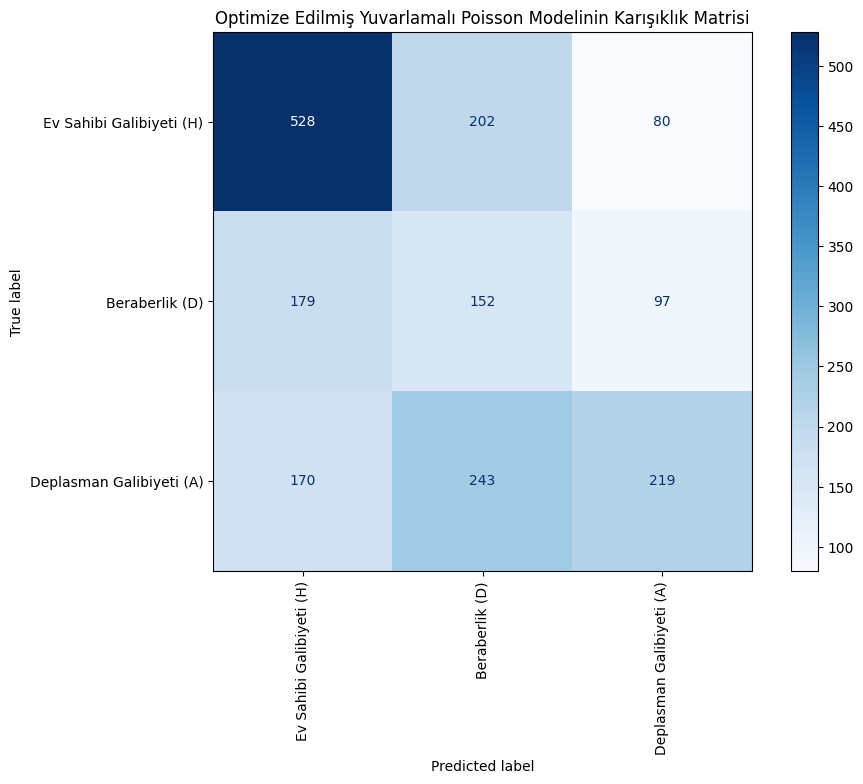

In [18]:
print(f"Optimize Edilmiş Modelin Genel Doğruluğu: {accuracy:.4f} (%{accuracy*100:.2f})")
print("-" * 75)
target_names = ['Ev Sahibi Galibiyeti (H)', 'Beraberlik (D)', 'Deplasman Galibiyeti (A)']
print("Sınıflandırma Raporu:\n")
print(classification_report(y_test_original, final_predictions, target_names=target_names))
print("-" * 75)
print("Karışıklık Matrisi:")
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay.from_predictions(
    y_test_original, final_predictions, display_labels=target_names,
    cmap='Blues', xticks_rotation='vertical', ax=ax
)
plt.title('Optimize Edilmiş Yuvarlamalı Poisson Modelinin Karışıklık Matrisi')
plt.show()

---

## Adım 3: İnteraktif Tahmin Arayüzü

Bu son bölümde, eğittiğimiz ve optimize ettiğimiz modelleri kullanarak canlı maç tahminleri yapabilen interaktif bir fonksiyon oluşturulur. Bu fonksiyon, modelin yeteneklerini doğrudan test etme ve gerçek dünya senaryoları için olasılıklar üretme imkanı tanır.

### Fonksiyonun İşleyişi:

1.  **Takım Listesi:** Fonksiyon ilk çalıştığında, veri setinde bulunan tüm takımların tam isimlerini bir liste halinde, her birine bir numara atanmış şekilde ekrana yazdırır. Bu, kullanıcıların takım isimlerini doğru bir şekilde girmesini sağlar ve olası yazım hatalarını önler.

2.  **Kullanıcı Girdisi:** Program, kullanıcıdan **Ev Sahibi** ve **Deplasman** takımlarını temsil eden numaraları girmesini ister. Girdiler doğrulanır; geçersiz veya aynı numaraların girilmesi durumunda kullanıcıya bir uyarı mesajı gösterilir.

3.  **Anlık Veri Çekimi:** Kullanıcının seçtiği takımlar için, veri setindeki **en güncel** istatistikler (en son ELO puanları, form metrikleri, hücum/savunma güçleri vb.) otomatik olarak bulunur.

4.  **Canlı Tahmin:** Bu güncel istatistikler, daha önce eğitilmiş olan `model_home_goals` ve `model_away_goals` uzman modellerine beslenir. Modeller, bu verilere dayanarak her iki takım için beklenen gol sayılarını tahmin eder.

5.  **Olasılıkların Sunulması:** Elde edilen gol beklentileri, Poisson dağılımı kullanılarak analiz edilir ve sonuçlar kullanıcıya aşağıdaki formatta, anlaşılır bir şekilde sunulur:
    *   Modelin beklediği ortalama gol sayıları (örn: Ev Sahibi 1.71 - Deplasman 0.99).
    *   Ev Sahibi takımın kazanma olasılığı (yüzde olarak).
    *   Beraberlik olasılığı (yüzde olarak).
    *   Deplasman takımının kazanma olasılığı (yüzde olarak).

6.  **Sürekli Kullanım:** Bir tahmin tamamlandıktan sonra, program kullanıcıya yeni bir tahmin yapmak isteyip istemediğini sorar ve "evet" cevabı verildiği sürece döngü devam eder.

Bu interaktif arayüz, geliştirilen karmaşık modelin somut ve pratik bir çıktısı olarak hizmet eder.

In [22]:
from scipy.stats import poisson
import numpy as np
import pandas as pd

In [23]:
def interactive_match_predictor(df, model_home, model_away):
   
    # Takımları Listele ve Numaralandır 
    all_teams = sorted(list(df['HomeTeam'].unique()))
    team_map = {i + 1: team for i, team in enumerate(all_teams)}

    print("--- Premier League Maç Tahmin Modeline Hoş Geldiniz ---")
    
    while True:
        print("\nLütfen aşağıdaki listeden takımları numaralarını girerek seçin:")
        for num, team in team_map.items():
            print(f"{num}: {team}")
        print("-" * 50)

        try:
            home_num = int(input("Ev Sahibi Takım Numarası: "))
            away_num = int(input("Deplasman Takım Numarası: "))

            if home_num not in team_map or away_num not in team_map:
                print("\nHATA: Geçersiz takım numarası girdiniz. Lütfen listedeki numaralardan birini seçin.")
                continue
            
            if home_num == away_num:
                print("\nHATA: Ev sahibi ve deplasman takımı aynı olamaz. Lütfen farklı takımlar seçin.")
                continue

            home_team = team_map[home_num]
            away_team = team_map[away_num]

        except ValueError:
            print("\nHATA: Lütfen geçerli bir sayı girin.")
            continue
            
        # Takımların En Güncel İstatistiklerini Bul
        try:
            last_home_game = df[df['HomeTeam'] == home_team].iloc[-1]
            last_away_game = df[df['AwayTeam'] == away_team].iloc[-1]
        except IndexError:
            print(f"\nUYARI: Takımlardan biri ({home_team} veya {away_team}) için yeterli geçmiş veri bulunamadı. Lütfen başka takımlar deneyin.")
            continue

        # Tahmin İçin Özellikleri Hazırla
        home_features_data = {
            'HomeElo_GD': last_home_game['HomeElo_GD'],
            'Elo_Diff_GD': last_home_game['HomeElo_GD'] - last_away_game['AwayElo_GD'],
            'H_last5_avg_GS': last_home_game['H_last5_avg_GS'],
            'H_last5_Points': last_home_game['H_last5_Points'],
            'A_last5_avg_GC': last_away_game['A_last5_avg_GC'],
            'H_AttackStrength': last_home_game['H_AttackStrength'],
            'A_DefenseStrength': last_away_game['A_DefenseStrength']
        }
        away_features_data = {
            'AwayElo_GD': last_away_game['AwayElo_GD'],
            'Elo_Diff_GD': last_home_game['HomeElo_GD'] - last_away_game['AwayElo_GD'],
            'A_last5_avg_GS': last_away_game['A_last5_avg_GS'],
            'A_last5_Points': last_away_game['A_last5_Points'],
            'H_last5_avg_GC': last_home_game['H_last5_avg_GC'],
            'A_AttackStrength': last_away_game['A_AttackStrength'],
            'H_DefenseStrength': last_home_game['H_DefenseStrength']
        }
        home_df = pd.DataFrame([home_features_data])
        away_df = pd.DataFrame([away_features_data])

        # Beklenen Gol Sayılarını Tahmin Et ve Olasılıkları Hesapla
        exp_home_goals = model_home.predict(home_df)[0]
        exp_away_goals = model_away.predict(away_df)[0]
        
        max_goals = 7
        prob_matrix = np.outer(
            poisson.pmf(np.arange(0, max_goals + 1), exp_home_goals),
            poisson.pmf(np.arange(0, max_goals + 1), exp_away_goals)
        )
        prob_home_win = np.sum(np.tril(prob_matrix, -1))
        prob_draw = np.sum(np.diag(prob_matrix))
        prob_away_win = np.sum(np.triu(prob_matrix, 1))
        total_prob = prob_home_win + prob_draw + prob_away_win
        if total_prob > 0:
            prob_home_win /= total_prob
            prob_draw /= total_prob
            prob_away_win /= total_prob

        print(f"\n--- Maç Tahmini: {home_team} vs {away_team} ---")
        print(f"Modelin Beklediği Ortalama Goller: Ev Sahibi {exp_home_goals:.2f} - Deplasman {exp_away_goals:.2f}")
        print("-" * 50)
        print(f"{home_team} Kazanma Olasılığı: %{prob_home_win*100:.2f}")
        print(f"Beraberlik Olasılığı: %{prob_draw*100:.2f}")
        print(f"{away_team} Kazanma Olasılığı: %{prob_away_win*100:.2f}")
        print("-" * 50)
        
        another_prediction = input("Başka bir tahmin yapmak ister misiniz? (e/h): ").lower()
        if another_prediction != 'e':
            print("Model kapatılıyor. İyi günler!")
            break



##### İnteraktif Fonksiyonu Başlat

In [25]:
interactive_match_predictor(df, model_home_goals, model_away_goals)

--- Premier League Maç Tahmin Modeline Hoş Geldiniz ---

Lütfen aşağıdaki listeden takımları numaralarını girerek seçin:
1: Arsenal
2: Aston Villa
3: Birmingham
4: Blackburn
5: Blackpool
6: Bolton
7: Bournemouth
8: Bradford
9: Brentford
10: Brighton
11: Burnley
12: Cardiff
13: Charlton
14: Chelsea
15: Coventry
16: Crystal Palace
17: Derby
18: Everton
19: Fulham
20: Huddersfield
21: Hull
22: Ipswich
23: Leeds
24: Leicester
25: Liverpool
26: Luton
27: Man City
28: Man United
29: Middlesbrough
30: Newcastle
31: Norwich
32: Nott'm Forest
33: Portsmouth
34: QPR
35: Reading
36: Sheffield United
37: Southampton
38: Stoke
39: Sunderland
40: Swansea
41: Tottenham
42: Watford
43: West Brom
44: West Ham
45: Wigan
46: Wolves
--------------------------------------------------

--- Maç Tahmini: Liverpool vs Arsenal ---
Modelin Beklediği Ortalama Goller: Ev Sahibi 1.71 - Deplasman 0.99
--------------------------------------------------
Liverpool Kazanma Olasılığı: %54.34
Beraberlik Olasılığı: %23.92
